In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [30]:
state_labs = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

def fetch_data_kw(kw):
    dir = '/media/johnattan/LaCie/Twitter_Terms/' + kw + '/GEO-Tweets.csv'
    df = pd.read_csv(dir, index_col=None, header=0)
    df = df.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1', 'id'], axis = 1)

    return df

def fetch_data_cts(date):
    dir = '/media/johnattan/LaCie/Twitter_Terms/State_Counts/2020-6.csv'
    df = pd.read_csv(dir, index_col=None, header=0)
    
    return df

def collapse_count(df):
    states = []
    counts = []
    for state in df.State.unique():
        states.append(state)
        counts.append(np.sum(df[df.State == state].Counts))
    
    collapsed_cts = pd.DataFrame([])
    collapsed_cts['State'] = states
    collapsed_cts['Count'] = counts
    
    return collapsed_cts

def subset_date(df, date):
    time_vec = df.created_at.values
    inds = [x[0:7] == date for x in df.created_at.values]   
    
    return df[inds]

def count_by_state(df):
    counts = df.state.value_counts()
    
    # Fill zero states
    zero_states = list(set(state_labs) - set(list(counts.index.values)))
    
    for state in zero_states:
        counts = counts.append(pd.Series([0], index=[state]))
    
    return counts

def plot_choropleth(kw_counts, total_counts, locations, kw='', date=''):
    
    fig = go.Figure(data=go.Choropleth(
        locations=locations, # Spatial coordinates
        z = kw_counts / total_counts, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Reds',
        colorbar_title = "Tweet Counts / Tweet Volume",
        #range_color = [0.005, 0.02],
        zmin=0.00, zmax=0.001,
    ))

    if kw == '':
        fig.update_layout(
            title_text = 'Tweets related to Covid-19',
            geo_scope='usa', # limite map scope to USA
        )
    else:
        fig.update_layout(
            title_text = 'Tweets related to Covid-19 and ' + kw + ' ' + date,
            geo_scope='usa', # limite map scope to USA
        )
    fig.show()
    fig.write_image('figures/' + kw + '/' + kw + '-' + date + '.png')


def build_dataframe(kw, dates):
    
    df_kw = fetch_data_kw(kw)
    
    dfs = []
    
    for date in dates:
        df_kw_date = subset_date(df_kw, date)
        kw_cts = count_by_state(df_kw_date)

        df_cts = collapse_count(fetch_data_cts(date))
        kw_cts = kw_cts.sort_index()
        
        dfs.append(pd.DataFrame({'State': kw_cts.index.values, 'Date': date,'Count' : kw_cts.values / df_cts.Count.values}))

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df.to_csv('Train_Data/' + kw + '-' + dates[0] + '--' + dates[-1] + '.csv')

    return df

def plotty_plots(kw, dates, renderer = 'png'):
    state_count = build_dataframe(kw, dates)

    Months = pd.DataFrame({'2020-01': '2020-01', '2020-02': '2020-02', '2020-03': '2020-03', 
                           '2020-04': '2020-04', '2020-05': '2020-05', '2020-06': '2020-06'}, index=[0])
    
    rows = 2
    cols = 3
    
    fig = make_subplots(
        rows=rows, cols=cols,
        specs = [[{'type': 'choropleth'} for c in np.arange(cols)] for r in np.arange(rows)],
        subplot_titles = list(Months.loc[0,:]))
    
    for i, month in enumerate(Months):
        result = state_count[['State', 'Count']][state_count.Date == month]
        fig.add_trace(go.Choropleth(
            locations=result.State,
            z = result.Count,
            locationmode = 'USA-states', # set of locations match entries in `locations`
            marker_line_color='white',
            zmin = 0,
            zmax = max(state_count['Count']),
            colorbar_title = "tweets",
        ), row = i//cols+1, col = i%cols+1)

    fig.update_layout(
        title_text = 'Tweets related to Covid-19 and ' + kw,
        **{'geo' + str(i) + '_scope': 'usa' for i in [''] + np.arange(2,rows*cols+1).tolist()},
        )

#for index, trace in enumerate(fig.data):
#    fig.data[index].hovertemplate = 'State: %{location}<br>Shooting deaths: %{z:.2f} <extra></extra>'
    
    fig.show(renderer = renderer)
    fig.write_image('figures/' + kw + '/' + dates[0] + '--' + dates[-1] + '.png')


    

In [32]:
dates = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06']

plotty_plots('BEER', dates, renderer='firefox')

In [69]:
kws.index.values

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [67]:
kws.values / tots.Count.values

0     0.000752
1     0.000653
2     0.000690
3     0.000625
4     0.001233
5     0.000851
6     0.000912
7     0.000015
8     0.002223
9     0.000918
10    0.000704
11    0.000758
12    0.000630
13    0.000644
14    0.000850
15    0.000935
16    0.001034
17    0.001602
18    0.000644
19    0.000737
20    0.000660
21    0.001184
22    0.000853
23    0.000800
24    0.000674
25    0.000389
26    0.000753
27    0.000778
28    0.000948
29    0.000534
30    0.000941
31    0.000883
32    0.001079
33    0.000747
34    0.000778
35    0.015308
36    0.000685
37    0.000873
38    0.000782
39    0.000918
40    0.000747
41    0.000917
42    0.000767
43    0.000572
44    0.000829
45    0.000786
46    0.001250
47    0.001104
48    0.000724
49    0.001708
50    0.001262
Name: Count, dtype: float64

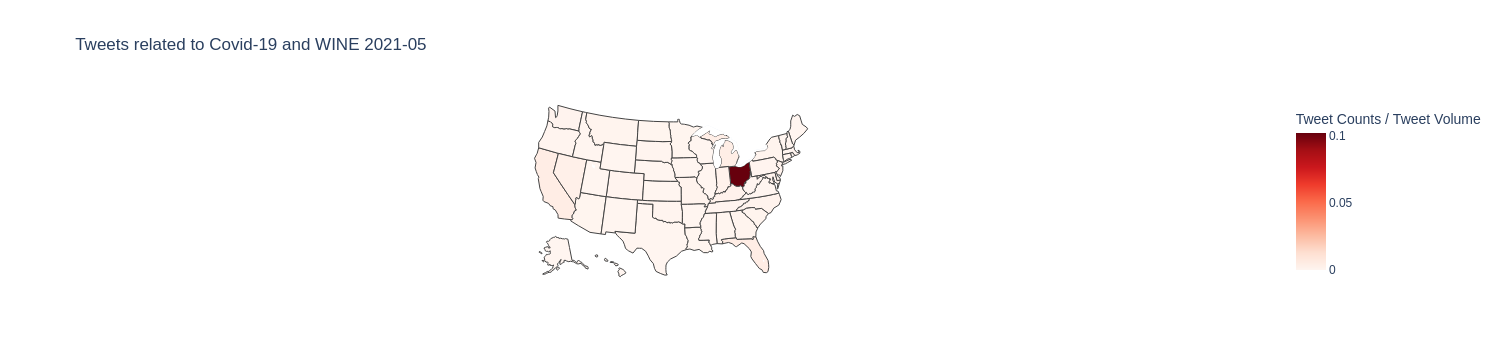

In [24]:
compare_plots('WINE', '2021-05')

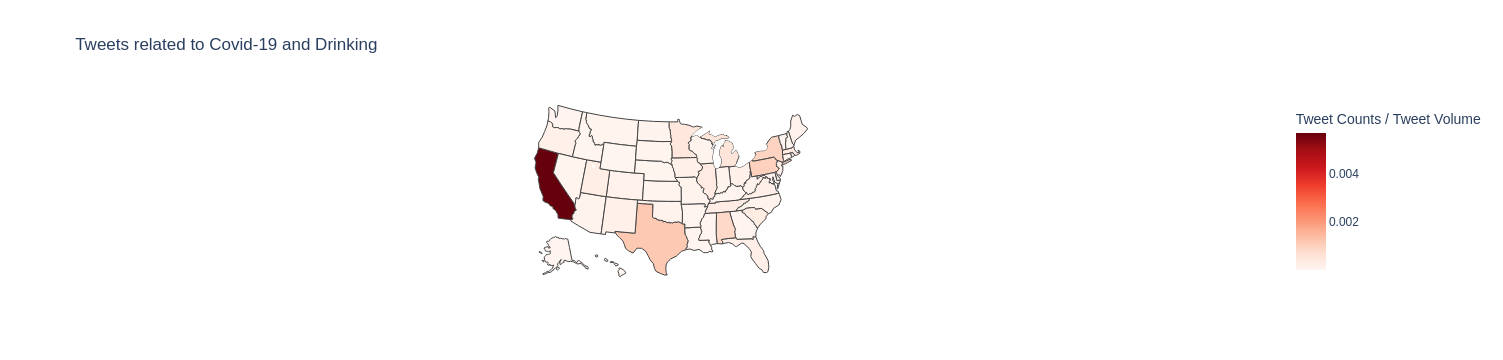

In [39]:
compare_plots('Drinking', '2021-05')

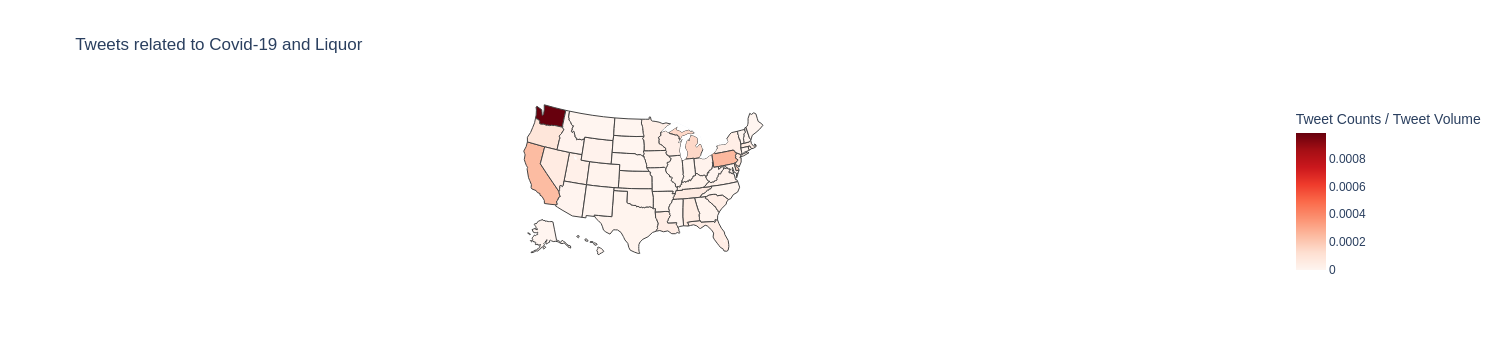

In [43]:
compare_plots('Liquor', '2021-05')

In [90]:
df = fetch_data_kw('BEER')
df.head()

,text,created_at,state
0,Hey! Free beer with proof of covid vax. Just l...,2021-04-01 00:03:23+00:00,NV
1,@ChicagoBeerSnob @voxdotcom If you ignore the ...,2021-04-01 00:10:53+00:00,FL
2,@thekidry The tweet had nothing to do with mas...,2021-04-01 00:21:13+00:00,TN
3,Free Krispy Kreme to 10-cent beers — perks for...,2021-04-01 00:28:33+00:00,WA
4,Free Krispy Kreme to 10-cent beers — perks for...,2021-04-01 00:28:36+00:00,KS


In [109]:
#df.iloc[24000].values
subset_date(df, '2020-05')

,text,created_at,state
56458,Officials in Seattle are reportedly giving add...,2020-05-01 00:04:58+00:00,CA
56459,"Oh, the humanity! 😳😱😭😭😭 #SaveTheBeer 🍺🍻🍺🍻 #OPE...",2020-05-01 00:05:55+00:00,GA
56460,Officials in Seattle are reportedly giving add...,2020-05-01 00:10:25+00:00,MO
56461,"Meet Buddy and Barley, the doggy duo deliverin...",2020-05-01 00:11:13+00:00,FL
56462,Hoppy Boston's Beer Thoughts/Links for April f...,2020-05-01 00:12:07+00:00,MA
...,...,...,...
72531,103-year-old woman celebrates beating Covid-19...,2020-05-31 23:58:23+00:00,NY
72532,103-year-old woman celebrates beating Covid-19...,2020-05-31 23:58:29+00:00,MD
72533,103-year-old woman celebrates beating Covid-19...,2020-05-31 23:58:47+00:00,GA
72534,103-year-old woman celebrates beating Covid-19...,2020-05-31 23:59:48+00:00,FL


In [20]:
# Alcohol, Beer, Drinking, Liquor, Wine
kw = 'BEER'
date = '2020-06'

df_kw = fetch_data_kw(kw)
df_kw = subset_date(df_kw, date)
kw_cts = count_by_state(df_kw)
    
df_cts = collapse_count(fetch_data_cts(date))
#plot_choropleth(kw_cts.values, df_cts['Count'], kw_cts.index.values, kw=kw, date=date)


CA    1512
TX    1305
FL    1039
NY     934
WA     577
IL     453
OH     443
PA     391
NJ     348
MA     327
TN     294
GA     289
NC     285
VA     283
CO     273
OR     271
MI     269
AZ     256
MN     213
WI     183
MD     170
IN     162
NV     132
KS     121
CT     117
KY     116
LA     113
SC     113
MO     109
ME      92
AL      83
OK      82
NM      79
IA      73
AR      60
UT      54
DE      47
ID      45
AK      42
RI      41
NH      40
MT      37
HI      35
NE      34
MS      31
VT      29
WV      24
WY      14
ND       9
SD       9
DC       6
Name: state, dtype: int64

In [25]:

fig = px.choropleth(df_kw, geojson=states, locations='state', color=kw_cts,
                           color_continuous_scale="Viridis",
                           range_color=(0.005, 0.2),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

NameError: name 'states' is not defined